**PROJECT: TO DEVELOP CNN DEEP LEARNING MODEL FOR BREAST BREAST LESION CLASSIFICATION ON ULTRASOUND IMAGES**

The objective is to develop a deep learning model that can correctly classify ultrasound images as normal, benign or malignant. Correct predictions will enable earlier detection of breast cancer on ultrasound.

**Import Relevant Libraries**

In [1]:
from IPython import get_ipython
from IPython.display import display
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"frederickdamptey","key":"bb9318a59ce526e9b4c4a31c89e58b42"}'}

**Import, Unzip And Load Files From Kaggle**

In [3]:
import os
import zipfile

# Create Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the right location
!mv kaggle.json /root/.kaggle/

# Set proper permissions
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download aryashah2k/breast-ultrasound-images-dataset
!unzip breast-ultrasound-images-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
Archive:  breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT

Extract Only B-Mode Images, Normalize And Encode Labels

In [9]:
import os
import cv2
import glob
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define dataset directory and categories
dataset_dir = 'Dataset_BUSI_with_GT'
categories = ["normal", "benign", "malignant"]
imageSize = 120

# Initialize data and labels
data = []
labels = []

# Glob pattern to find all PNG images recursively
case_image_pattern = os.path.join(dataset_dir, '**', '*.png')
all_image_paths = glob.glob(case_image_pattern, recursive=True)

# Filter out mask images
case_image_paths = [path for path in all_image_paths if 'mask' not in path]

# Process images
for path in case_image_paths:
    # Determine category from the folder name
    for category in categories:
        if os.path.join(dataset_dir, category) in path:
            class_num = categories.index(category)
            break
    else:
        continue  # Skip if category not matched (safe fallback)

    # Load image
    img_array = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img_array is not None:
        resized_img = cv2.resize(img_array, (imageSize, imageSize))
        data.append(resized_img)
        labels.append(class_num)

# Convert to NumPy arrays and reshape for model input
data = np.array(data).reshape(-1, imageSize, imageSize, 1)
labels = np.array(labels)

# Encode labels (though they're already numeric, this keeps things general)
label_encoder = LabelEncoder()
y_data_encoded = label_encoder.fit_transform(labels)


Display Few Images

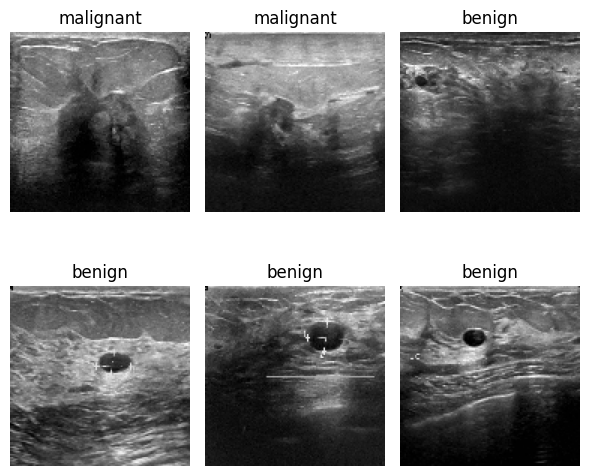

In [10]:
import matplotlib.pyplot as plt
import random

# Map numeric labels back to category names
label_map = {index: category for index, category in enumerate(categories)}

# Select 6 random indices
random_indices = random.sample(range(len(data)), 6)

# Plot the 6 images: 3 rows x 3 columns
plt.figure(figsize=(6, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(data[idx].reshape(imageSize, imageSize), cmap='gray')
    plt.title(label_map[labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()


**Plot Class Distribution**

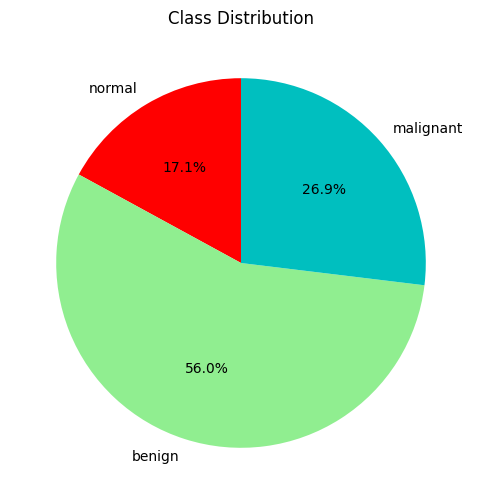

In [7]:
import seaborn as sns

# Calculate class counts
class_counts = np.bincount(y_data_encoded)

# Define custom colors for each class
colors = ['red', 'lightgreen', 'c']  # Example colors

# Plot Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")
plt.show()

Split Data Into Training And Testing Sets

In [11]:
# Split Data into Train & Test

X_train, X_test, y_train, y_test = train_test_split(
    data, y_data_encoded, test_size=0.15, random_state=42, stratify=y_data_encoded
)


**Import, Adapt And Train Pretrained Models**

MODEL 1: RESNET50 MODEL

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image size for ResNet50
imageSize = 120

# Ensure grayscale images are converted to RGB (3 channels)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

# Define ResNet50 base model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(imageSize, imageSize, 3))

# Unfreeze only the last 2 layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Define transfer learning model with Global Max Pooling
def create_model():
    model = Sequential([
        base_model,
        GlobalMaxPooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),  # Increased regularization
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
histories = []

# Early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

for fold, (train_index, val_index) in enumerate(kf.split(X_train_rgb), 1):
    print(f"\nTraining Fold {fold}/5...")

    X_train_fold, X_val_fold = X_train_rgb[train_index], X_train_rgb[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    ResNet_model = create_model()

    # Apply data augmentation
    train_generator = datagen.flow(X_train_fold, y_train_fold, batch_size=32)  # Lowered batch size

    history = ResNet_model.fit(train_generator, validation_data=(X_val_fold, y_val_fold),
                               epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

    histories.append(history)

    # Evaluate the model and store the score for each fold
    _, score = ResNet_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    scores.append(score)

# Compute overall training and validation accuracy
mean_train_acc = np.mean([history.history['accuracy'][-1] for history in histories])
mean_val_acc = np.mean([history.history['val_accuracy'][-1] for history in histories])

print(f"\nOverall Training Accuracy: {mean_train_acc:.4f}")
print(f"Overall Validation Accuracy: {mean_val_acc:.4f}")




Training Fold 1/5...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 833ms/step - accuracy: 0.5709 - loss: 2.7951 - val_accuracy: 0.7918 - val_loss: 2.2145 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7390 - loss: 2.3850 - val_accuracy: 0.8476 - val_loss: 2.1657 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.7892 - loss: 2.2197 - val_accuracy: 0.8439 - val_loss: 2.0790 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7989 - loss: 2.1569 - val_accuracy: 0.8290 - val_loss: 2.1193 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8311 - loss: 2.0960 - val_accuracy: 0.7918 - val_loss: 2.4334 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8389 - loss: 2.0080 - val_accuracy: 0.8736 - val_loss: 1.9694 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy:

PLOT LEARNING CURVES

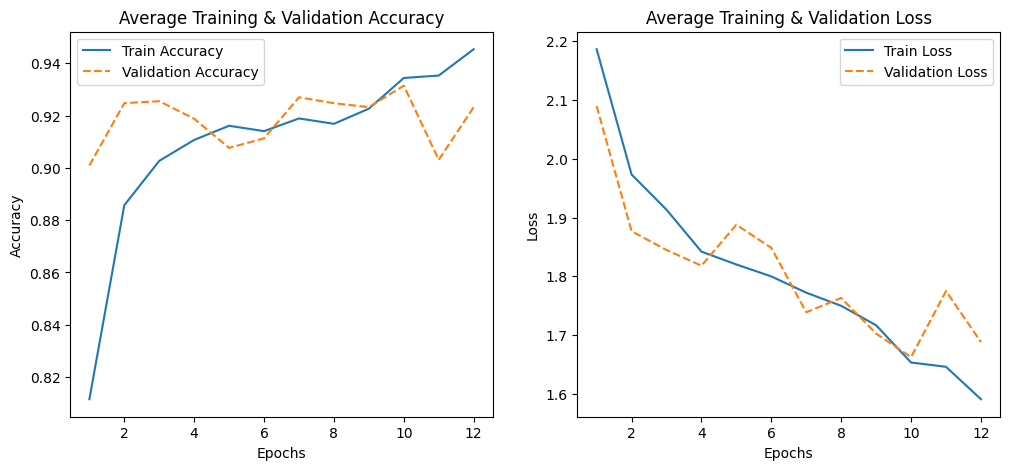

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot averaged learning curves across all folds
def plot_avg_learning_curves(histories):
    if not histories:
        print("No training histories provided.")
        return

    # Find minimum number of epochs across all histories
    min_epochs = min(len(history.history['accuracy']) for history in histories)

    # Truncate histories to the minimum number of epochs
    truncated_histories = [
        {key: history.history[key][:min_epochs] for key in history.history}
        for history in histories
    ]

    avg_train_acc = np.mean([h['accuracy'] for h in truncated_histories], axis=0)
    avg_val_acc = np.mean([h['val_accuracy'] for h in truncated_histories], axis=0)
    avg_train_loss = np.mean([h['loss'] for h in truncated_histories], axis=0)
    avg_val_loss = np.mean([h['val_loss'] for h in truncated_histories], axis=0)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, min_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, min_epochs + 1), avg_val_acc, label='Validation Accuracy', linestyle='dashed')
    plt.title('Average Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, min_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, min_epochs + 1), avg_val_loss, label='Validation Loss', linestyle='dashed')
    plt.title('Average Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plots
    plt.show()

# Call the function to plot the learning curves
plot_avg_learning_curves(histories)

**NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN**

Model Evaluation


Final Test Evaluation:
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9100 - loss: 1.6785
Test Accuracy: 0.9198, Test Loss: 1.6020
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 544ms/step

Classification Report: 

              precision    recall  f1-score   support

      normal       0.89      0.80      0.84        40
      benign       0.90      0.99      0.94       134
   malignant       1.00      0.86      0.92        63

    accuracy                           0.92       237
   macro avg       0.93      0.88      0.90       237
weighted avg       0.92      0.92      0.92       237



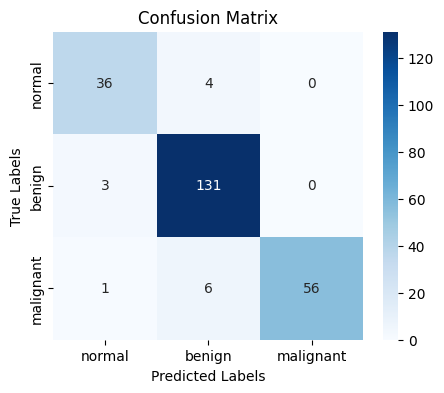

In [ ]:
# Evaluate final test accuracy using the model from the last fold
print("\nFinal Test Evaluation:")
test_loss, test_accuracy = ResNet_model.evaluate(X_test_rgb, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


# Get predictions for the test set
y_pred = ResNet_model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Print classification report
print("\nClassification Report:", "\n")
print(classification_report(y_test, y_pred_classes, target_names=categories))



# Optional: Display confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Compute Metric Values And Plot AUC_ROC curve

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Average AUROC (ResNet): 0.9638


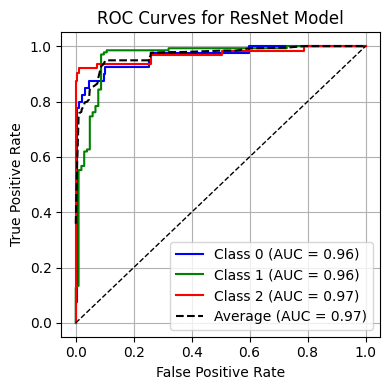


Class 0 (ResNet):
  Sensitivity (Recall): 0.8000
  Specificity: 0.9797

Class 1 (ResNet):
  Sensitivity (Recall): 0.9851
  Specificity: 0.8544

Class 2 (ResNet):
  Sensitivity (Recall): 0.8571
  Specificity: 1.0000

Average Sensitivity (ResNet): 0.8807
Average Specificity (ResNet): 0.9447


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


# Get predicted probabilities for ResNet model
y_pred_probs_resnet = ResNet_model.predict(X_test_rgb)
y_pred_classes_resnet = np.argmax(y_pred_probs_resnet, axis=1)

# Binarize test labels (one-hot encode)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 3 classes
n_classes = y_test_bin.shape[1]

# Compute AUROC per class
fpr_resnet = dict()
tpr_resnet = dict()
roc_auc_resnet = dict()

for i in range(n_classes):
    fpr_resnet[i], tpr_resnet[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs_resnet[:, i])
    roc_auc_resnet[i] = auc(fpr_resnet[i], tpr_resnet[i])

# Average AUROC
avg_auroc_resnet = np.mean(list(roc_auc_resnet.values()))
print(f"\nAverage AUROC (ResNet): {avg_auroc_resnet:.4f}")

# --- Plot ROC Curves for ResNet ---
plt.figure(figsize=(4, 4))
colors = ['blue', 'green', 'red']

for i in range(n_classes):
    plt.plot(fpr_resnet[i], tpr_resnet[i], color=colors[i],
             label=f'Class {i} (AUC = {roc_auc_resnet[i]:.2f})')

# Average ROC curve
all_fpr_resnet = np.unique(np.concatenate([fpr_resnet[i] for i in range(n_classes)]))
mean_tpr_resnet = np.zeros_like(all_fpr_resnet)
for i in range(n_classes):
    mean_tpr_resnet += np.interp(all_fpr_resnet, fpr_resnet[i], tpr_resnet[i])

mean_tpr_resnet /= n_classes
fpr_resnet["macro"] = all_fpr_resnet
tpr_resnet["macro"] = mean_tpr_resnet
roc_auc_resnet["macro"] = auc(fpr_resnet["macro"], tpr_resnet["macro"])

plt.plot(fpr_resnet["macro"], tpr_resnet["macro"],
         label=f'Average (AUC = {roc_auc_resnet["macro"]:.2f})',
         color='black', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ResNet Model')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

# --- Compute Sensitivity and Specificity for ResNet ---
cm_resnet = confusion_matrix(y_test, y_pred_classes_resnet)

sensitivity_resnet = []
specificity_resnet = []

for i in range(n_classes):
    TP = cm_resnet[i, i]
    FN = np.sum(cm_resnet[i, :]) - TP
    FP = np.sum(cm_resnet[:, i]) - TP
    TN = np.sum(cm_resnet) - (TP + FN + FP)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_resnet.append(sens)
    specificity_resnet.append(spec)

    print(f"\nClass {i} (ResNet):")
    print(f"  Sensitivity (Recall): {sens:.4f}")
    print(f"  Specificity: {spec:.4f}")

# Average Sensitivity and Specificity
avg_sensitivity_resnet = np.mean(sensitivity_resnet)
avg_specificity_resnet = np.mean(specificity_resnet)

print(f"\nAverage Sensitivity (ResNet): {avg_sensitivity_resnet:.4f}")
print(f"Average Specificity (ResNet): {avg_specificity_resnet:.4f}")


MODEL 2: EFFICIENTNET

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image size for EfficientNetB0
imageSize = 120

X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

# Define EfficientNetB0 base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(imageSize, imageSize, 3))

# Unfreeze only the last 2 layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Define transfer learning model with Global Max Pooling
def create_model():
    model = Sequential([
        base_model,
        GlobalMaxPooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),  # Increased regularization
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
histories = []

# Early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

for fold, (train_index, val_index) in enumerate(kf.split(X_train_rgb), 1):
    print(f"\nTraining Fold {fold}/5...")

    X_train_fold, X_val_fold = X_train_rgb[train_index], X_train_rgb[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create model
    EfficientNet_model = create_model()

    # Apply data augmentation
    train_generator = datagen.flow(X_train_fold, y_train_fold, batch_size=32)

    history = EfficientNet_model.fit(train_generator, validation_data=(X_val_fold, y_val_fold),
                               epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

    histories.append(history)

    # Evaluate the model and store the score for each fold
    _, score = EfficientNet_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    scores.append(score)

# Compute overall training and validation accuracy
mean_train_acc = np.mean([history.history['accuracy'][-1] for history in histories])
mean_val_acc = np.mean([history.history['val_accuracy'][-1] for history in histories])

print(f"\nOverall Training Accuracy: {mean_train_acc:.4f}")
print(f"Overall Validation Accuracy: {mean_val_acc:.4f}")


Training Fold 1/5...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4749 - loss: 2.8208 - val_accuracy: 0.7100 - val_loss: 2.4266 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.6755 - loss: 2.3074 - val_accuracy: 0.6989 - val_loss: 2.2536 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7292 - loss: 2.1547 - val_accuracy: 0.7026 - val_loss: 2.3277 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.7250 - loss: 2.1588 - val_accuracy: 0.7286 - val_loss: 2.1796 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7418 - loss: 2.0695 - val_accuracy: 0.7546 - val_loss: 1.9863 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7792 - loss: 2.0111 - val_accuracy: 0.7472 - val_loss: 1.9521 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0

Plot Learning Curves

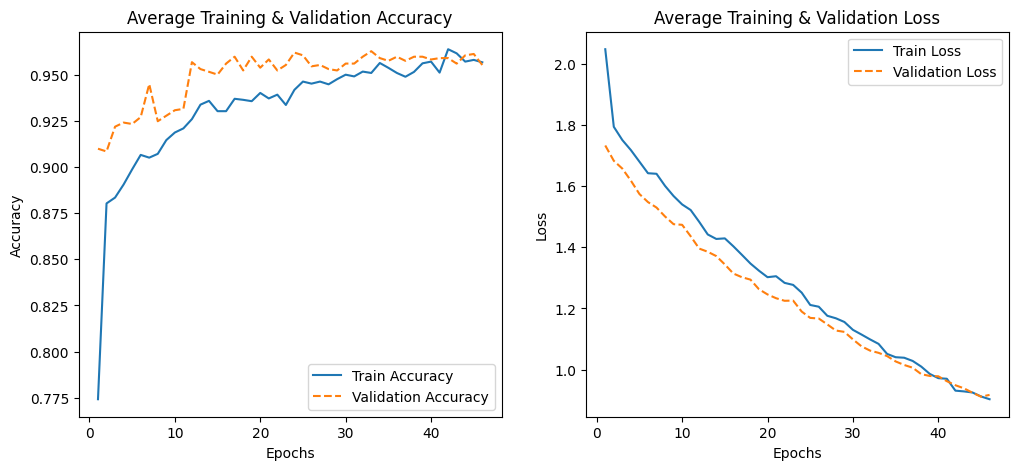

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot averaged learning curves across all folds
def plot_avg_learning_curves(histories):
    if not histories:
        print("No training histories provided.")
        return

    # Find minimum number of epochs across all histories
    min_epochs = min(len(history.history['accuracy']) for history in histories)

    # Truncate histories to the minimum number of epochs
    truncated_histories = [
        {key: history.history[key][:min_epochs] for key in history.history}
        for history in histories
    ]

    avg_train_acc = np.mean([h['accuracy'] for h in truncated_histories], axis=0)
    avg_val_acc = np.mean([h['val_accuracy'] for h in truncated_histories], axis=0)
    avg_train_loss = np.mean([h['loss'] for h in truncated_histories], axis=0)
    avg_val_loss = np.mean([h['val_loss'] for h in truncated_histories], axis=0)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, min_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, min_epochs + 1), avg_val_acc, label='Validation Accuracy', linestyle='dashed')
    plt.title('Average Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, min_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, min_epochs + 1), avg_val_loss, label='Validation Loss', linestyle='dashed')
    plt.title('Average Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plots
    plt.show()

# Call the function to plot the learning curves
plot_avg_learning_curves(histories)

Predict And Evaluate Model


Final Test Evaluation:
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 0.9467 - loss: 0.8614
Test Accuracy: 0.9494, Test Loss: 0.8182
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 848ms/step

Classification Report: 

              precision    recall  f1-score   support

      normal       0.95      0.88      0.91        40
      benign       0.96      0.97      0.96       134
   malignant       0.94      0.95      0.94        63

    accuracy                           0.95       237
   macro avg       0.95      0.93      0.94       237
weighted avg       0.95      0.95      0.95       237



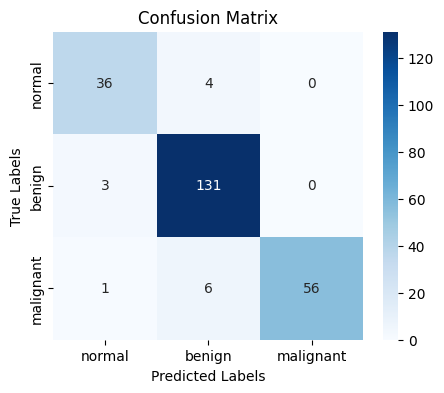

In [ ]:
# Evaluate final test accuracy using the model from the last fold
print("\nFinal Test Evaluation:")

# Assign the EfficientNet_model from the last fold to a variable outside the loop
Efficient_model = histories[-1].model

# Use the assigned Efficient_model for evaluation
test_loss, test_accuracy = Efficient_model.evaluate(X_test_rgb, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


# Get predictions for the test set
y_pred = Efficient_model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Print classification report
print("\nClassification Report:", "\n")
print(classification_report(y_test, y_pred_classes, target_names=categories))



# Display confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Plot AUC_ROC and Compute Metrics

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 839ms/step

Average AUROC (EfficientNet): 0.9830


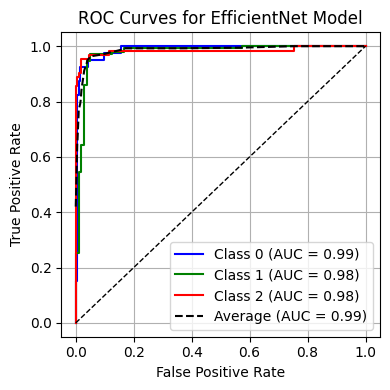


Class 0 (EfficientNet):
  Sensitivity (Recall): 0.8750
  Specificity: 0.9898

Class 1 (EfficientNet):
  Sensitivity (Recall): 0.9701
  Specificity: 0.9417

Class 2 (EfficientNet):
  Sensitivity (Recall): 0.9524
  Specificity: 0.9770

Average Sensitivity (EfficientNet): 0.9325
Average Specificity (EfficientNet): 0.9695


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


# Get predicted probabilities for EfficientNet model
y_pred_probs_eff = Efficient_model.predict(X_test_rgb)
y_pred_classes_eff = np.argmax(y_pred_probs_eff, axis=1)

# --- Calculate AUROC and Specificity for EfficientNet ---

# Binarize test labels (one-hot encode)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 3 classes
n_classes = y_test_bin.shape[1]

# Compute AUROC per class
fpr_eff = dict()
tpr_eff = dict()
roc_auc_eff = dict()

for i in range(n_classes):
    fpr_eff[i], tpr_eff[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs_eff[:, i])
    roc_auc_eff[i] = auc(fpr_eff[i], tpr_eff[i])

# Average AUROC
avg_auroc_eff = np.mean(list(roc_auc_eff.values()))
print(f"\nAverage AUROC (EfficientNet): {avg_auroc_eff:.4f}")

# --- Plot ROC Curves for EfficientNet ---
plt.figure(figsize=(4, 4))
colors = ['blue', 'green', 'red']

for i in range(n_classes):
    plt.plot(fpr_eff[i], tpr_eff[i], color=colors[i],
             label=f'Class {i} (AUC = {roc_auc_eff[i]:.2f})')

# Average ROC curve
all_fpr_eff = np.unique(np.concatenate([fpr_eff[i] for i in range(n_classes)]))
mean_tpr_eff = np.zeros_like(all_fpr_eff)
for i in range(n_classes):
    mean_tpr_eff += np.interp(all_fpr_eff, fpr_eff[i], tpr_eff[i])

mean_tpr_eff /= n_classes
fpr_eff["macro"] = all_fpr_eff
tpr_eff["macro"] = mean_tpr_eff
roc_auc_eff["macro"] = auc(fpr_eff["macro"], tpr_eff["macro"])

plt.plot(fpr_eff["macro"], tpr_eff["macro"],
         label=f'Average (AUC = {roc_auc_eff["macro"]:.2f})',
         color='black', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for EfficientNet Model')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

# --- Compute Sensitivity and Specificity for EfficientNet ---
cm_eff = confusion_matrix(y_test, y_pred_classes_eff)

sensitivity_eff = []
specificity_eff = []

for i in range(n_classes):
    TP = cm_eff[i, i]
    FN = np.sum(cm_eff[i, :]) - TP
    FP = np.sum(cm_eff[:, i]) - TP
    TN = np.sum(cm_eff) - (TP + FN + FP)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_eff.append(sens)
    specificity_eff.append(spec)

    print(f"\nClass {i} (EfficientNet):")
    print(f"  Sensitivity (Recall): {sens:.4f}")
    print(f"  Specificity: {spec:.4f}")

# Average Sensitivity and Specificity
avg_sensitivity_eff = np.mean(sensitivity_eff)
avg_specificity_eff = np.mean(specificity_eff)

print(f"\nAverage Sensitivity (EfficientNet): {avg_sensitivity_eff:.4f}")
print(f"Average Specificity (EfficientNet): {avg_specificity_eff:.4f}")


MODEL 3: INCEPTION MODEL

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image size for EfficientNetB0
imageSize = 120

# Converted grayscale images to RGB (3 channels)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

# Define EfficientNetB0 base model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(imageSize, imageSize, 3))

# Unfreeze only the last 2 layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Define transfer learning model with Global Max Pooling
def create_model():
    model = Sequential([
        base_model,
        GlobalMaxPooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),  # Increased regularization
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
histories = []

# Early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

for fold, (train_index, val_index) in enumerate(kf.split(X_train_rgb), 1):
    print(f"\nTraining Fold {fold}/5...")

    X_train_fold, X_val_fold = X_train_rgb[train_index], X_train_rgb[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Changed ResNet_model to EfficientNet_model
    EfficientNet_model = create_model()

    # Apply data augmentation
    train_generator = datagen.flow(X_train_fold, y_train_fold, batch_size=32)  # Lowered batch size

    history = EfficientNet_model.fit(train_generator, validation_data=(X_val_fold, y_val_fold), # Changed ResNet_model to EfficientNet_model
                               epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

    histories.append(history)

    # Evaluate the model and store the score for each fold
    _, score = EfficientNet_model.evaluate(X_val_fold, y_val_fold, verbose=0) # Changed ResNet_model to EfficientNet_model
    scores.append(score)

# Compute overall training and validation accuracy
mean_train_acc = np.mean([history.history['accuracy'][-1] for history in histories])
mean_val_acc = np.mean([history.history['val_accuracy'][-1] for history in histories])

print(f"\nOverall Training Accuracy: {mean_train_acc:.4f}")
print(f"Overall Validation Accuracy: {mean_val_acc:.4f}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Training Fold 1/5...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.5717 - loss: 2.8731 - val_accuracy: 0.5576 - val_loss: 5.2309 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.6967 - loss: 2.4077 - val_accuracy: 0.6357 - val_loss: 3.1987 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7241 - loss: 2.2952 - val_accuracy: 0.6729 - val_loss: 2.6544 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.7401 - loss: 2.1838 - val_accuracy: 0.7807 - val_loss: 2.1864 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7350 - loss: 2.2348 - val_accuracy: 0.8401 - val_loss: 2.3316 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.7706 - loss: 2.1762 - val_accuracy: 0.8587 - val_loss: 2.1119 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0

Plot Learning Curves To Visualize Training Performance

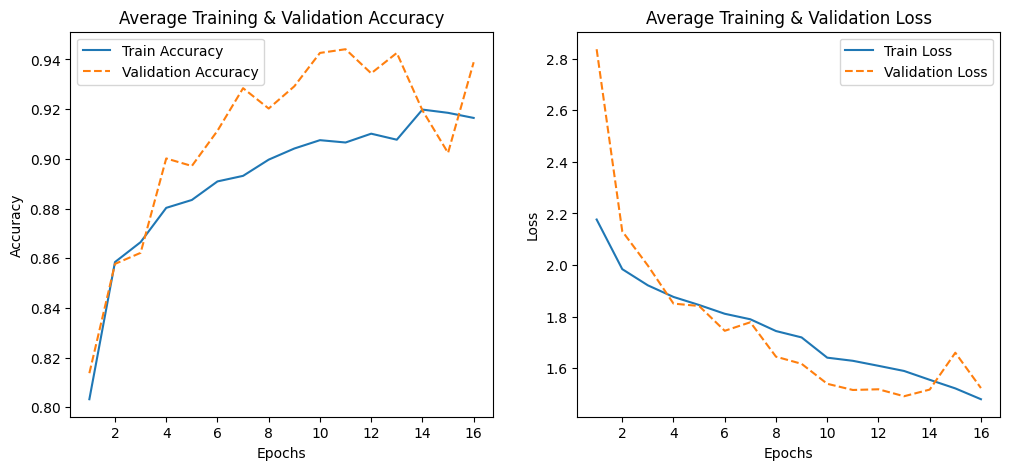

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot averaged learning curves across all folds
def plot_avg_learning_curves(histories):
    if not histories:
        print("No training histories provided.")
        return

    # Find minimum number of epochs across all histories
    min_epochs = min(len(history.history['accuracy']) for history in histories)

    # Truncate histories to the minimum number of epochs
    truncated_histories = [
        {key: history.history[key][:min_epochs] for key in history.history}
        for history in histories
    ]

    avg_train_acc = np.mean([h['accuracy'] for h in truncated_histories], axis=0)
    avg_val_acc = np.mean([h['val_accuracy'] for h in truncated_histories], axis=0)
    avg_train_loss = np.mean([h['loss'] for h in truncated_histories], axis=0)
    avg_val_loss = np.mean([h['val_loss'] for h in truncated_histories], axis=0)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, min_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, min_epochs + 1), avg_val_acc, label='Validation Accuracy', linestyle='dashed')
    plt.title('Average Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, min_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, min_epochs + 1), avg_val_loss, label='Validation Loss', linestyle='dashed')
    plt.title('Average Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plots
    plt.show()

# Call the function to plot the learning curves
plot_avg_learning_curves(histories)

Predict And Evaluate Model


Final Test Evaluation:
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.9368 - loss: 0.8134
Test Accuracy: 0.9409, Test Loss: 0.7862


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 826ms/step

Classification Report: 

              precision    recall  f1-score   support

      normal       0.88      0.95      0.92        40
      benign       0.93      0.96      0.95       134
   malignant       1.00      0.89      0.94        63

    accuracy                           0.94       237
   macro avg       0.94      0.93      0.94       237
weighted avg       0.94      0.94      0.94       237



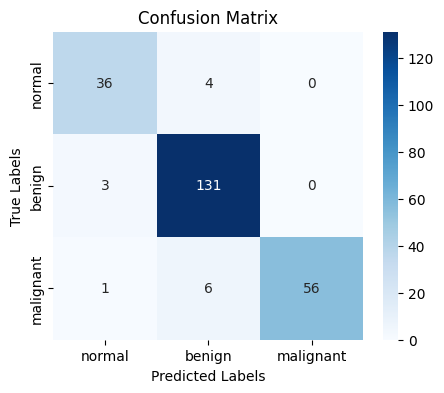

In [ ]:
# Evaluate final test accuracy using the model from the last fold
print("\nFinal Test Evaluation:")

# Assign the Inception_model from the last fold to a variable outside the loop
Inception_model = histories[-1].model

# Now use the assigned Efficient_model for evaluation
test_loss, test_accuracy = Inception_model.evaluate(X_test_rgb, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


# Get predictions for the test set
y_pred = Inception_model.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Print classification report
print("\nClassification Report:", "\n")
print(classification_report(y_test, y_pred_classes, target_names=categories))



# Optional: Display confusion matrix as a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Metric Computation and Plot


Average AUROC (InceptionV3): 0.9815


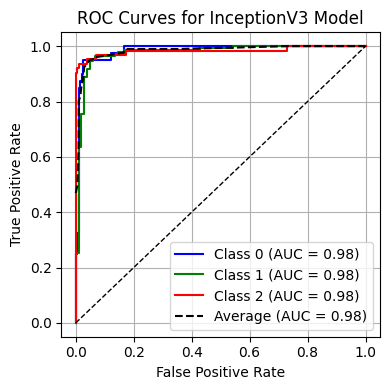


Class 0 (InceptionV3):
  Sensitivity (Recall): 0.9500
  Specificity: 0.9746

Class 1 (InceptionV3):
  Sensitivity (Recall): 0.9627
  Specificity: 0.9126

Class 2 (InceptionV3):
  Sensitivity (Recall): 0.8889
  Specificity: 1.0000

Average Sensitivity (InceptionV3): 0.9339

Average Specificity (InceptionV3): 0.9624


In [ ]:
# --- Calculate AUROC and Specificity ---

# Binarize the test labels for AUROC (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes
n_classes = y_test_bin.shape[1]

# Compute AUROC for each class
fpr_incep = dict()
tpr_incep = dict()
roc_auc_incep = dict()

for i in range(n_classes):
    fpr_incep[i], tpr_incep[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs_incep[:, i])
    roc_auc_incep[i] = auc(fpr_incep[i], tpr_incep[i])

# --- Calculate and print average AUROC ---
avg_auroc_incep = np.mean(list(roc_auc_incep.values()))
print(f"\nAverage AUROC (InceptionV3): {avg_auroc_incep:.4f}")

# --- Plot ROC Curves for InceptionV3 ---
plt.figure(figsize=(4, 4))
colors = ['blue', 'green', 'red']

# Plot class-specific ROC curves
for i in range(n_classes):
    plt.plot(fpr_incep[i], tpr_incep[i], color=colors[i],
             label=f'Class {i} (AUC = {roc_auc_incep[i]:.2f})')

# --- Calculate and plot average ROC curve ---
all_fpr_incep = np.unique(np.concatenate([fpr_incep[i] for i in range(n_classes)]))
mean_tpr_incep = np.zeros_like(all_fpr_incep)
for i in range(n_classes):
    mean_tpr_incep += np.interp(all_fpr_incep, fpr_incep[i], tpr_incep[i])

mean_tpr_incep /= n_classes
fpr_incep["macro"] = all_fpr_incep
tpr_incep["macro"] = mean_tpr_incep
roc_auc_incep["macro"] = auc(fpr_incep["macro"], tpr_incep["macro"])

# Plot average ROC curve
plt.plot(fpr_incep["macro"], tpr_incep["macro"],
         label=f'Average (AUC = {roc_auc_incep["macro"]:.2f})',
         color='black', linestyle='--')


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for InceptionV3 Model')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

# --- Compute Sensitivity and Specificity per class for InceptionV3 ---
# Calculate confusion matrix for InceptionV3
# Assuming you have y_pred_classes for InceptionV3 predictions
cm_incep = confusion_matrix(y_test, y_pred_classes)

sensitivity_incep = []
specificity_incep = []

for i in range(n_classes):
    TP = cm_incep[i, i]
    FN = np.sum(cm_incep[i, :]) - TP
    FP = np.sum(cm_incep[:, i]) - TP
    TN = np.sum(cm_incep) - (TP + FN + FP)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_incep.append(sens)
    specificity_incep.append(spec)

    print(f"\nClass {i} (InceptionV3):")
    print(f"  Sensitivity (Recall): {sens:.4f}")
    print(f"  Specificity: {spec:.4f}")

# --- Calculate and print average Sensitivity and Specificity ---
avg_sensitivity_incep = np.mean(sensitivity_incep)
avg_specificity_incep = np.mean(specificity_incep)

print(f"\nAverage Sensitivity (InceptionV3): {avg_sensitivity_incep:.4f}")
print(f"\nAverage Specificity (InceptionV3): {avg_specificity_incep:.4f}")

Model 4: VGG16 MODEL

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Adjusted image size for VGG16
imageSize = 120

# Ensure grayscale images are converted to RGB (3 channels)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Resize images to match VGG16 expected input
X_train_rgb = tf.image.resize(X_train_rgb, (imageSize, imageSize)).numpy()
X_test_rgb = tf.image.resize(X_test_rgb, (imageSize, imageSize)).numpy()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

# Load VGG16 base model without top layer
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(imageSize, imageSize, 3))

# Unfreeze last 2 layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Define model architecture
def create_model():
    model = Sequential([
        base_model,
        GlobalMaxPooling2D(),
        BatchNormalization(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.002)),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []
histories = []

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

for fold, (train_index, val_index) in enumerate(kf.split(X_train_rgb), 1):
    print(f"\nTraining Fold {fold}/5...")

    X_train_fold, X_val_fold = X_train_rgb[train_index], X_train_rgb[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    VGG16_model = create_model()

    train_generator = datagen.flow(X_train_fold, y_train_fold, batch_size=32)

    history = VGG16_model.fit(
        train_generator,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    histories.append(history)

    _, score = VGG16_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    scores.append(score)

# Compute and print overall training/validation accuracy
mean_train_acc = np.mean([history.history['accuracy'][-1] for history in histories])
mean_val_acc = np.mean([history.history['val_accuracy'][-1] for history in histories])

print(f"\nOverall Training Accuracy: {mean_train_acc:.4f}")
print(f"Overall Validation Accuracy: {mean_val_acc:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Training Fold 1/5...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 640ms/step - accuracy: 0.4616 - loss: 2.1659 - val_accuracy: 0.6989 - val_loss: 1.9026 - learning_rate: 1.0000e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.6671 - loss: 1.7956 - val_accuracy: 0.7249 - val_loss: 2.1481 - learning_rate: 1.0000e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.7379 - loss: 1.6275 - val_accuracy: 0.7918 - val_loss: 1.4973 - learning_rate: 1.0000e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.8040 - loss: 1.4815 - val_accuracy: 0.7918 - val_loss: 1.4879 - learning_rate: 1.0000e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.7534 - loss: 1.5196 - val_accuracy: 0.8216 - val_loss: 1.4358 - learning_rate: 1.0000e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.7988 - loss: 1.4890 - val_accuracy: 0.8141 - val_loss: 1.4588 - learning_rate: 1.0000e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy:

Plot Learning Curves

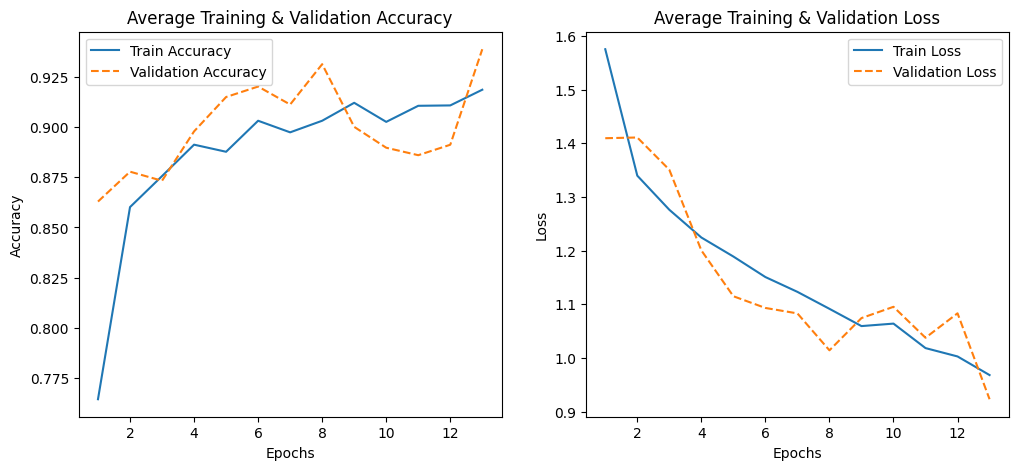

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot averaged learning curves across all folds
def plot_avg_learning_curves(histories):
    if not histories:
        print("No training histories provided.")
        return

    # Find minimum number of epochs across all histories
    min_epochs = min(len(history.history['accuracy']) for history in histories)

    # Truncate histories to the minimum number of epochs
    truncated_histories = [
        {key: history.history[key][:min_epochs] for key in history.history}
        for history in histories
    ]

    avg_train_acc = np.mean([h['accuracy'] for h in truncated_histories], axis=0)
    avg_val_acc = np.mean([h['val_accuracy'] for h in truncated_histories], axis=0)
    avg_train_loss = np.mean([h['loss'] for h in truncated_histories], axis=0)
    avg_val_loss = np.mean([h['val_loss'] for h in truncated_histories], axis=0)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, min_epochs + 1), avg_train_acc, label='Train Accuracy')
    plt.plot(range(1, min_epochs + 1), avg_val_acc, label='Validation Accuracy', linestyle='dashed')
    plt.title('Average Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, min_epochs + 1), avg_train_loss, label='Train Loss')
    plt.plot(range(1, min_epochs + 1), avg_val_loss, label='Validation Loss', linestyle='dashed')
    plt.title('Average Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plots
    plt.show()

# Call the function to plot the learning curves
plot_avg_learning_curves(histories)

Predict And Evaluate Model


Final Test Evaluation (VGG16):
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9377 - loss: 0.6864
Test Accuracy: 0.9325, Test Loss: 0.6951
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step

Classification Report (VGG16): 

              precision    recall  f1-score   support

      normal       0.97      0.90      0.94        40
      benign       0.90      0.99      0.94       134
   malignant       0.98      0.84      0.91        63

    accuracy                           0.93       237
   macro avg       0.95      0.91      0.93       237
weighted avg       0.94      0.93      0.93       237



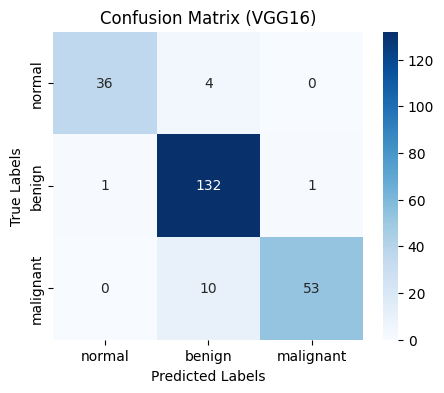

In [ ]:
# Assuming VGG16_model is the model trained in the last fold
# Evaluate final test accuracy using the model from the last fold
print("\nFinal Test Evaluation (VGG16):")

# Get the VGG16_model from the last training history
VGG16_model = histories[-1].model

test_loss, test_accuracy = VGG16_model.evaluate(X_test_rgb, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Get predictions for the test set
y_pred_vgg = VGG16_model.predict(X_test_rgb)
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)

# Print classification report
print("\nClassification Report (VGG16):", "\n")
print(classification_report(y_test, y_pred_classes_vgg, target_names=categories))

# Display confusion matrix as a heatmap
cm_vgg = confusion_matrix(y_test, y_pred_classes_vgg)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_vgg, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (VGG16)")
plt.show()

Compute Metrics And Plot AUC_ROC Curve


Average AUROC (VGG16): 0.9828


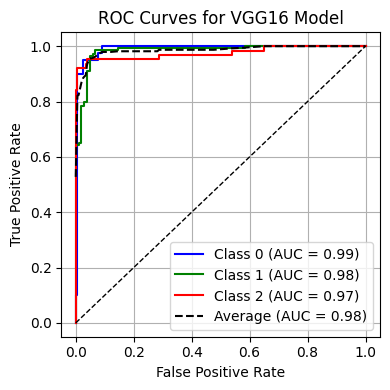


Class 0 (VGG16):
  Sensitivity (Recall): 0.9000
  Specificity: 0.9949

Class 1 (VGG16):
  Sensitivity (Recall): 0.9851
  Specificity: 0.8641

Class 2 (VGG16):
  Sensitivity (Recall): 0.8413
  Specificity: 0.9943

Average Sensitivity (VGG16): 0.9088

Average Specificity (VGG16): 0.9511


In [ ]:
# Calculate AUROC and Specificity for VGG16
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Calculate AUROC and Specificity for VGG16
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Binarize the test labels for AUROC (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute AUROC for each class
fpr_vgg = dict()
tpr_vgg = dict()
roc_auc_vgg = dict()

for i in range(n_classes):
    fpr_vgg[i], tpr_vgg[i], _ = roc_curve(y_test_bin[:, i], y_pred_vgg[:, i])
    roc_auc_vgg[i] = auc(fpr_vgg[i], tpr_vgg[i])

# --- Calculate and print average AUROC ---
avg_auroc_vgg = np.mean(list(roc_auc_vgg.values()))
print(f"\nAverage AUROC (VGG16): {avg_auroc_vgg:.4f}")

# --- Plot ROC Curves for VGG16 ---
plt.figure(figsize=(4, 4))
colors = ['blue', 'green', 'red']

# Plot class-specific ROC curves
for i in range(n_classes):
    plt.plot(fpr_vgg[i], tpr_vgg[i], color=colors[i],
             label=f'Class {i} (AUC = {roc_auc_vgg[i]:.2f})')

# --- Calculate and plot average ROC curve ---
# Micro-averaging to get overall FPR and TPR for all classes
all_fpr = np.unique(np.concatenate([fpr_vgg[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_vgg[i], tpr_vgg[i])

mean_tpr /= n_classes
fpr_vgg["macro"] = all_fpr
tpr_vgg["macro"] = mean_tpr
roc_auc_vgg["macro"] = auc(fpr_vgg["macro"], tpr_vgg["macro"])

# Plot average ROC curve
plt.plot(fpr_vgg["macro"], tpr_vgg["macro"],
         label=f'Average (AUC = {roc_auc_vgg["macro"]:.2f})',
         color='black', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for VGG16 Model')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


# Compute Sensitivity and Specificity per class for VGG16
sensitivity_vgg = []
specificity_vgg = []

for i in range(n_classes):
    TP = cm_vgg[i, i]
    FN = np.sum(cm_vgg[i, :]) - TP
    FP = np.sum(cm_vgg[:, i]) - TP
    TN = np.sum(cm_vgg) - (TP + FN + FP)

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_vgg.append(sens)
    specificity_vgg.append(spec)

    print(f"\nClass {i} (VGG16):")
    print(f"  Sensitivity (Recall): {sens:.4f}")
    print(f"  Specificity: {spec:.4f}")

# --- Calculate and print average Sensitivity and Specificity ---
avg_sensitivity_vgg = np.mean(sensitivity_vgg)
avg_specificity_vgg = np.mean(specificity_vgg)

print(f"\nAverage Sensitivity (VGG16): {avg_sensitivity_vgg:.4f}")
print(f"\nAverage Specificity (VGG16): {avg_specificity_vgg:.4f}")

**COMPARE MODEL PERFORMANCE**

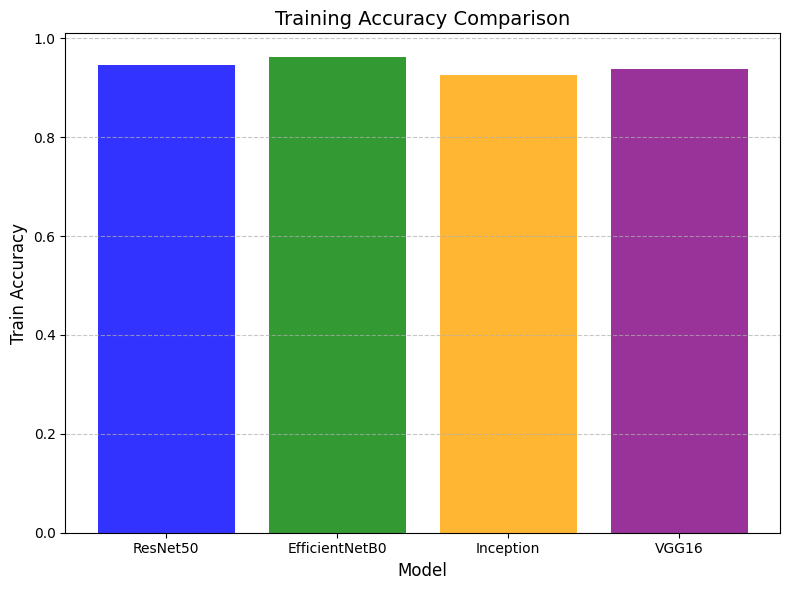

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
models = ['ResNet50', 'EfficientNetB0', 'Inception', 'VGG16']
train_accuracy = [0.947, 0.962, 0.925, 0.937]
colors = ['blue', 'green', 'orange', 'purple']

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, train_accuracy, color=colors, alpha=0.8)

# Add labels and title
plt.xlabel('Model', fontsize=12)
plt.ylabel('Train Accuracy', fontsize=12)
plt.title('Training Accuracy Comparison', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()